<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/techniques/1%20-%20Assumptions%20of%20Persistence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Persistence

Notebook from Alpha Workshop course: https://robotwealth.com/courses/alpha-trading-workshop/lessons/simple-data-analysis-patterns-in-the-lab/topic/assumptions-of-persistence-lags-leads-overlaps-and-scatterplots/

One of the most fundamental assumptions we often make when we try to model things, is that behaviour we observe in the future is going to stay similar to behaviour we've observed in the past.

In this lesson we discuss how we can use reason, eyeball, and data analysis to get clear about these assumptions and see if they are reasonable.<br></p>

We'll be looking at persistence of volatility and correlation. We cover the following techniques:

* periodic estimation
* lagging observations
* thinking about overlaps
* scatterplots
* correlations.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c(), extra_dependencies = c())
# cat(debug_msg)

# snippet: re set plot options v0.1
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpym1ADW/remotes7444a62ed4/RWLab-rwRtools-9bce833/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.34.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw macro quickstart v.0.1
quicksetup(pod = "Macro", path = ".")
prices %>% 
  head()

Set default bucket name to 'macro_research_pod'



Attempting download of  main_asset_classes_daily_ohlc.csv ...
Transferring main_asset_classes_daily_ohlc.csv ... data is 4.8 Mb please be patient...


ℹ Downloading main_asset_classes_daily_ohlc.csv

✔ Saved main_asset_classes_daily_ohlc.csv to ./main_asset_classes_daily_ohlc.cs…





main_asset_classes_daily_ohlc.csv successfully transferred


Rows: 63207 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (6): open, high, low, close, volume, closeadjusted
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,open,high,low,close,volume,closeadjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMB,1995-01-04,40.22193,40.22193,40.22193,40.22193,0,19.49731
GLD,1995-01-04,39.93568,39.93568,39.93568,39.93568,0,39.80411
IEF,1995-01-04,43.80437,43.80437,43.80437,43.80437,0,25.08416
TLT,1995-01-04,40.78683,40.78683,40.78683,40.78683,0,20.46596
VEA,1995-01-04,22.07549,22.07549,22.07549,22.07549,0,13.53363
VTI,1995-01-04,18.97111,18.97111,18.97111,18.97111,0,12.73688


In [4]:
prices %>%
  group_by(ticker) %>%
  summarize(n())

ticker,n()
<chr>,<int>
DBC,4304
DBMF,969
EMB,7097
GLD,7097
IEF,7097
NTSX,1160
TLT,7097
TMF,7095
VEA,7097


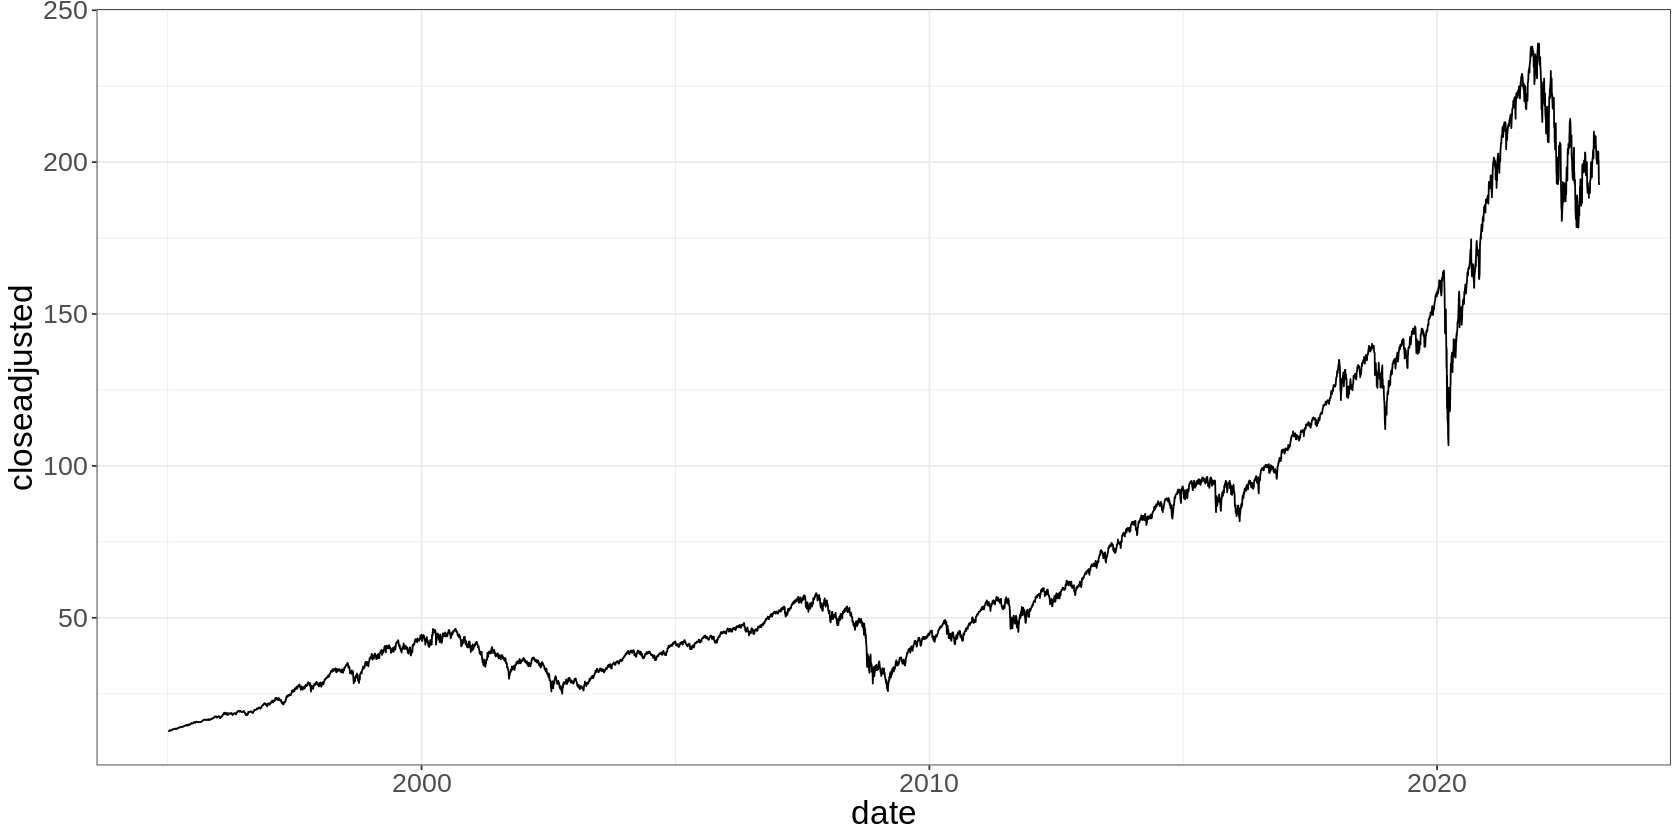

In [5]:
VTI <- prices %>%
  filter(ticker == 'VTI')

VTI %>%
  ggplot(aes(x=date, y=closeadjusted)) +
    geom_line()

We're happy that looks like VTI

# Estimate daily volatility of VTI

As the percentage range of the day

In [6]:
VTI %>% 
  head()

ticker,date,open,high,low,close,volume,closeadjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VTI,1995-01-04,18.97111,18.97111,18.97111,18.97111,0,12.73688
VTI,1995-01-05,18.95353,18.95353,18.95353,18.95353,0,12.72508
VTI,1995-01-06,18.96676,18.96676,18.96676,18.96676,0,12.73396
VTI,1995-01-09,18.97565,18.97565,18.97565,18.97565,0,12.73993
VTI,1995-01-10,19.01080,19.01080,19.01080,19.01080,0,12.76353
VTI,1995-01-11,19.01515,19.01515,19.01515,19.01515,0,12.76645


In [7]:
VTI <- VTI %>%
  filter(date >= '2010-05-07') %>%
  mutate(range_pct = (high/low - 1) * 100)

VTI %>% head()

ticker,date,open,high,low,close,volume,closeadjusted,range_pct
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VTI,2010-05-07,57.67,58.100,55.840,56.62,5416700,44.677,4.047278
VTI,2010-05-10,59.14,59.500,58.590,59.22,4080900,46.729,1.553166
VTI,2010-05-11,58.73,59.920,58.620,59.17,2164100,46.690,2.217673
VTI,2010-05-12,59.41,60.198,59.370,60.12,1394400,47.439,1.394644
VTI,2010-05-13,60.03,60.300,59.359,59.40,1289700,46.871,1.585269
VTI,2010-05-14,58.97,59.060,57.770,58.33,1997300,46.027,2.232993


Lead the data so tomorrows observation is aligned with todays

In [8]:
VTI <- VTI %>%
  arrange(date) %>%
  mutate(next_day_range_pct = lead(range_pct, 1)) %>%
  na.omit()
  
VTI %>% head()

ticker,date,open,high,low,close,volume,closeadjusted,range_pct,next_day_range_pct
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VTI,2010-05-07,57.67,58.100,55.840,56.62,5416700,44.677,4.047278,1.553166
VTI,2010-05-10,59.14,59.500,58.590,59.22,4080900,46.729,1.553166,2.217673
VTI,2010-05-11,58.73,59.920,58.620,59.17,2164100,46.690,2.217673,1.394644
VTI,2010-05-12,59.41,60.198,59.370,60.12,1394400,47.439,1.394644,1.585269
VTI,2010-05-13,60.03,60.300,59.359,59.40,1289700,46.871,1.585269,2.232993
VTI,2010-05-14,58.97,59.060,57.770,58.33,1997300,46.027,2.232993,2.653490


Plot a scatter of next day vol vs previous day vol

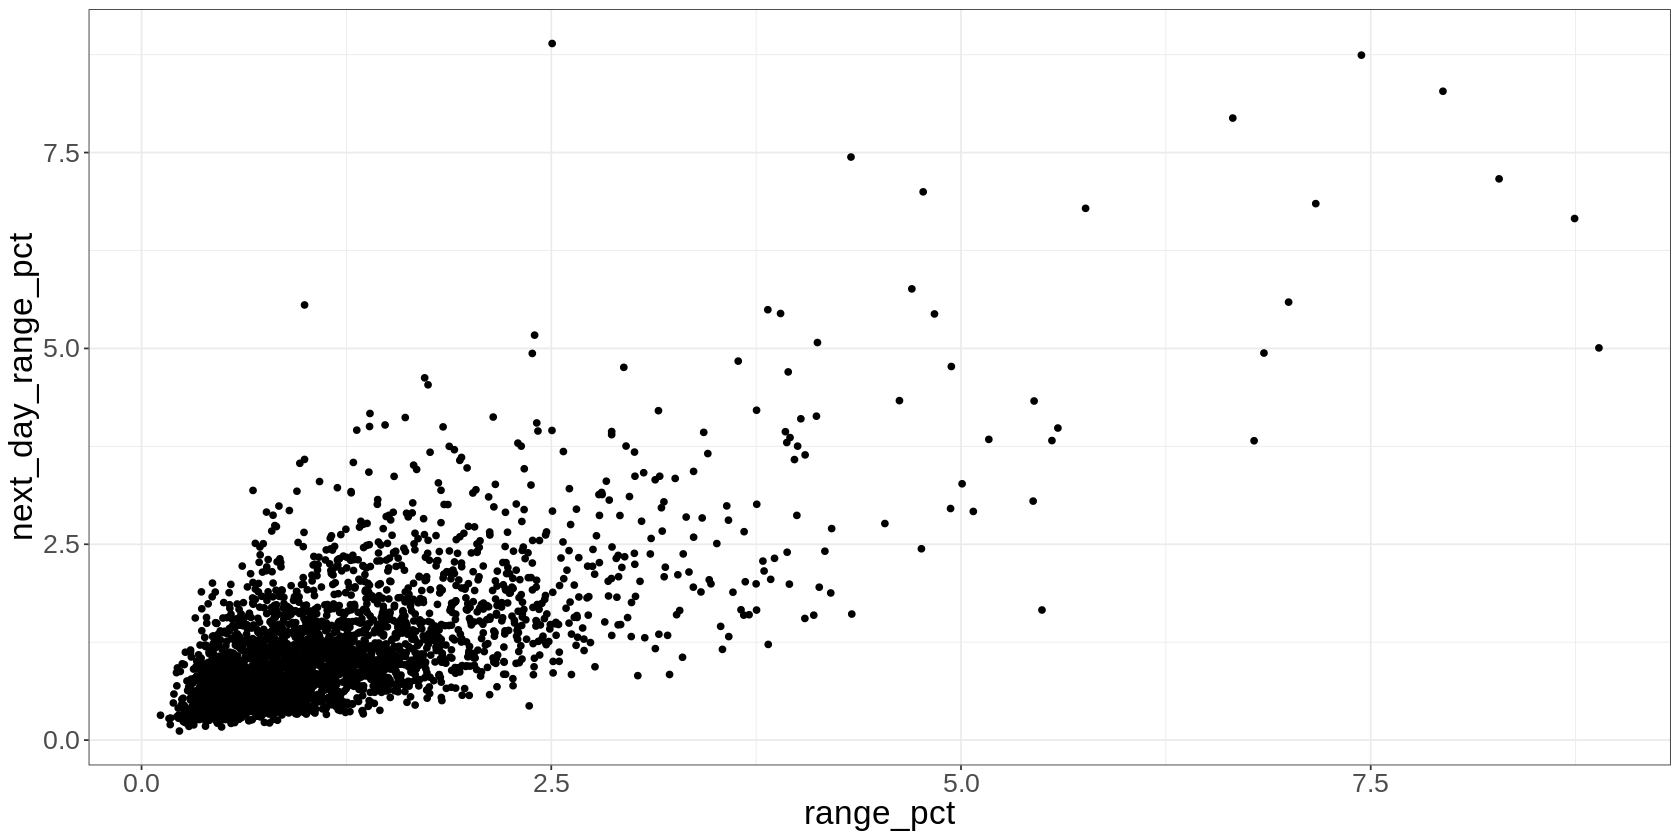

In [9]:
VTI %>% 
  ggplot(aes(x=range_pct, y=next_day_range_pct)) + 
    geom_point()

`geom_smooth()` using formula = 'y ~ x'


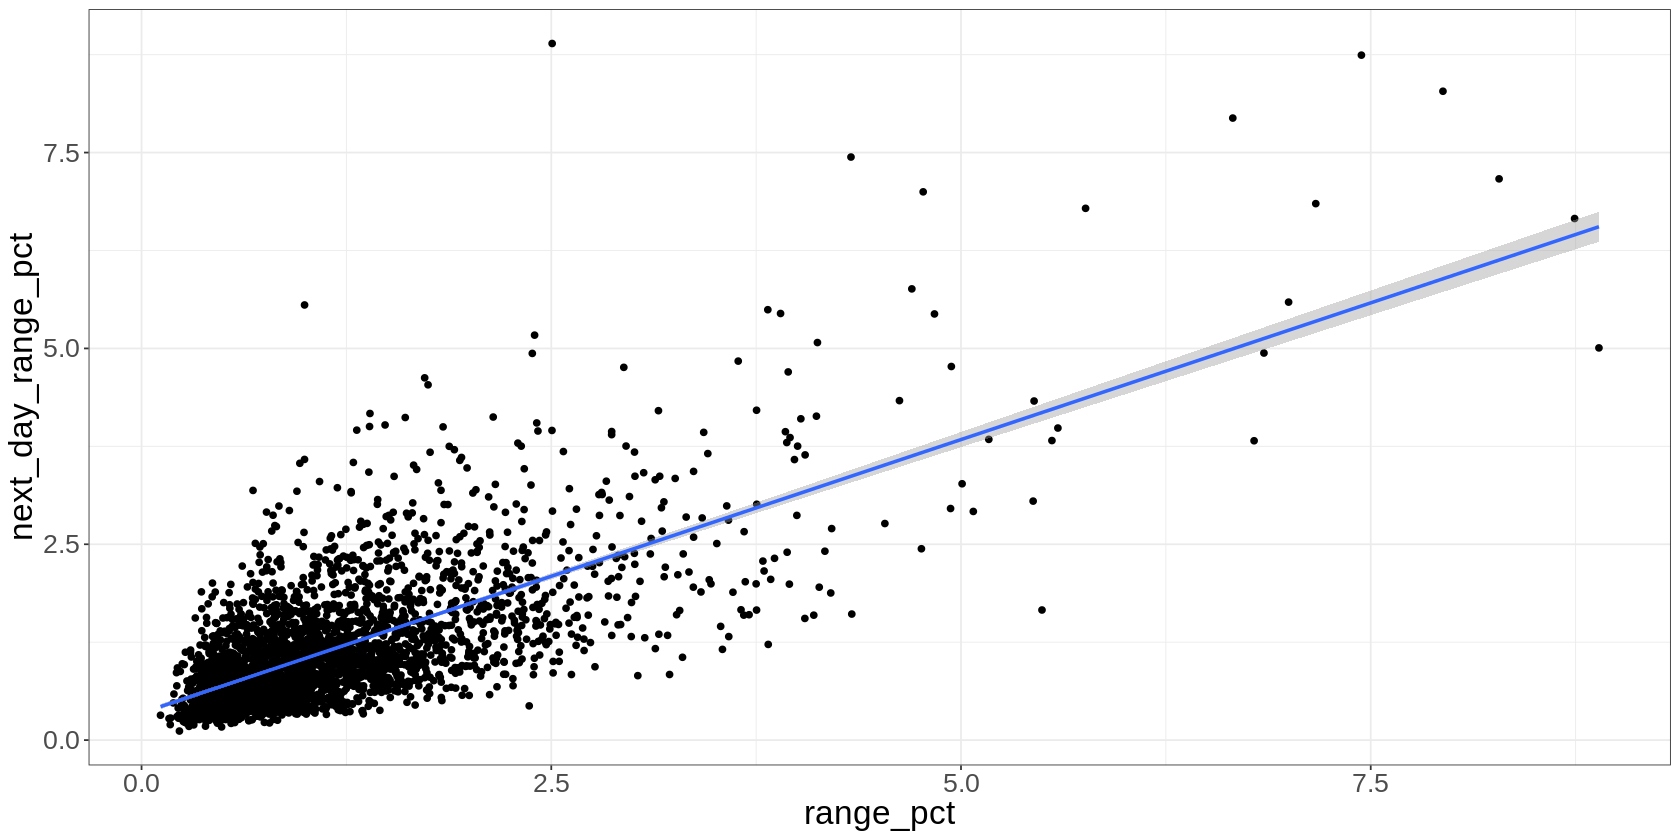

In [10]:
VTI %>% 
  ggplot(aes(x=range_pct, y=next_day_range_pct)) + 
    geom_point() + 
    geom_smooth(method = 'lm')

We would feel confident that the daily range is reasonably persistent.

# Split by year and see how consistent the effect we observe is

`geom_smooth()` using formula = 'y ~ x'


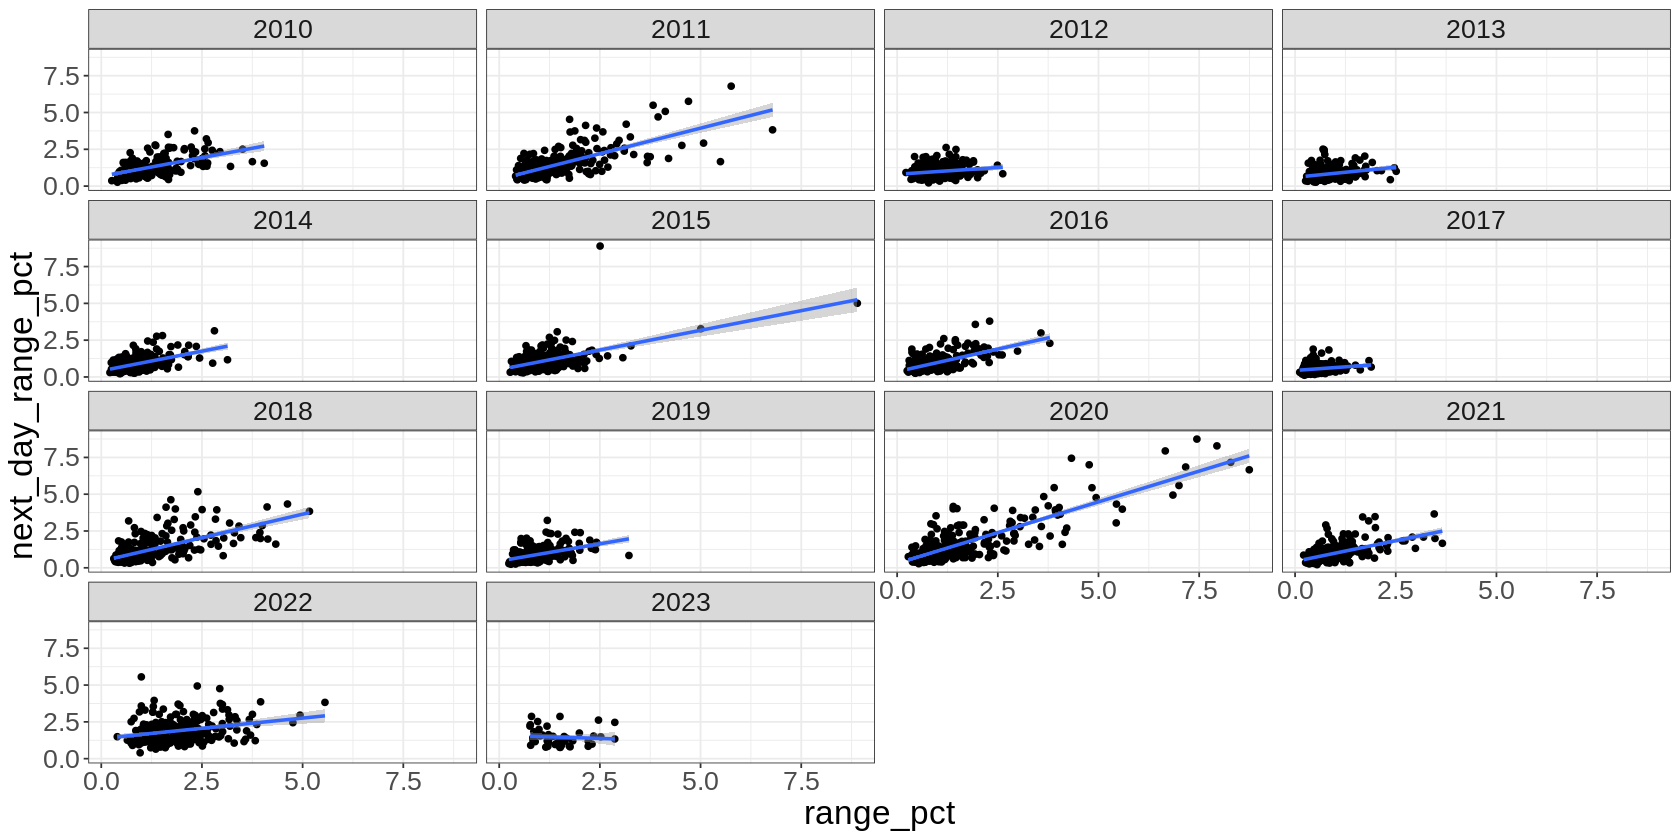

In [11]:
VTI %>%
  mutate(year = year(date)) %>%
  ggplot(aes(x=range_pct, y=next_day_range_pct)) + 
    geom_point() + 
    geom_smooth(method = 'lm') +
    facet_wrap(~year)


We can also take the correlation coefficient of range with next day range

In [12]:
VTI %>%
  mutate(year = year(date)) %>%
  group_by(year) %>%
  summarize(cor_coeff = cor(range_pct, next_day_range_pct))

year,cor_coeff
<dbl>,<dbl>
2010,0.53103629
2011,0.69453319
2012,0.18245156
2013,0.27500138
2014,0.53347380
2015,0.53420265
2016,0.61082877
2017,0.19701046
2018,0.63748316


`geom_smooth()` using formula = 'y ~ x'


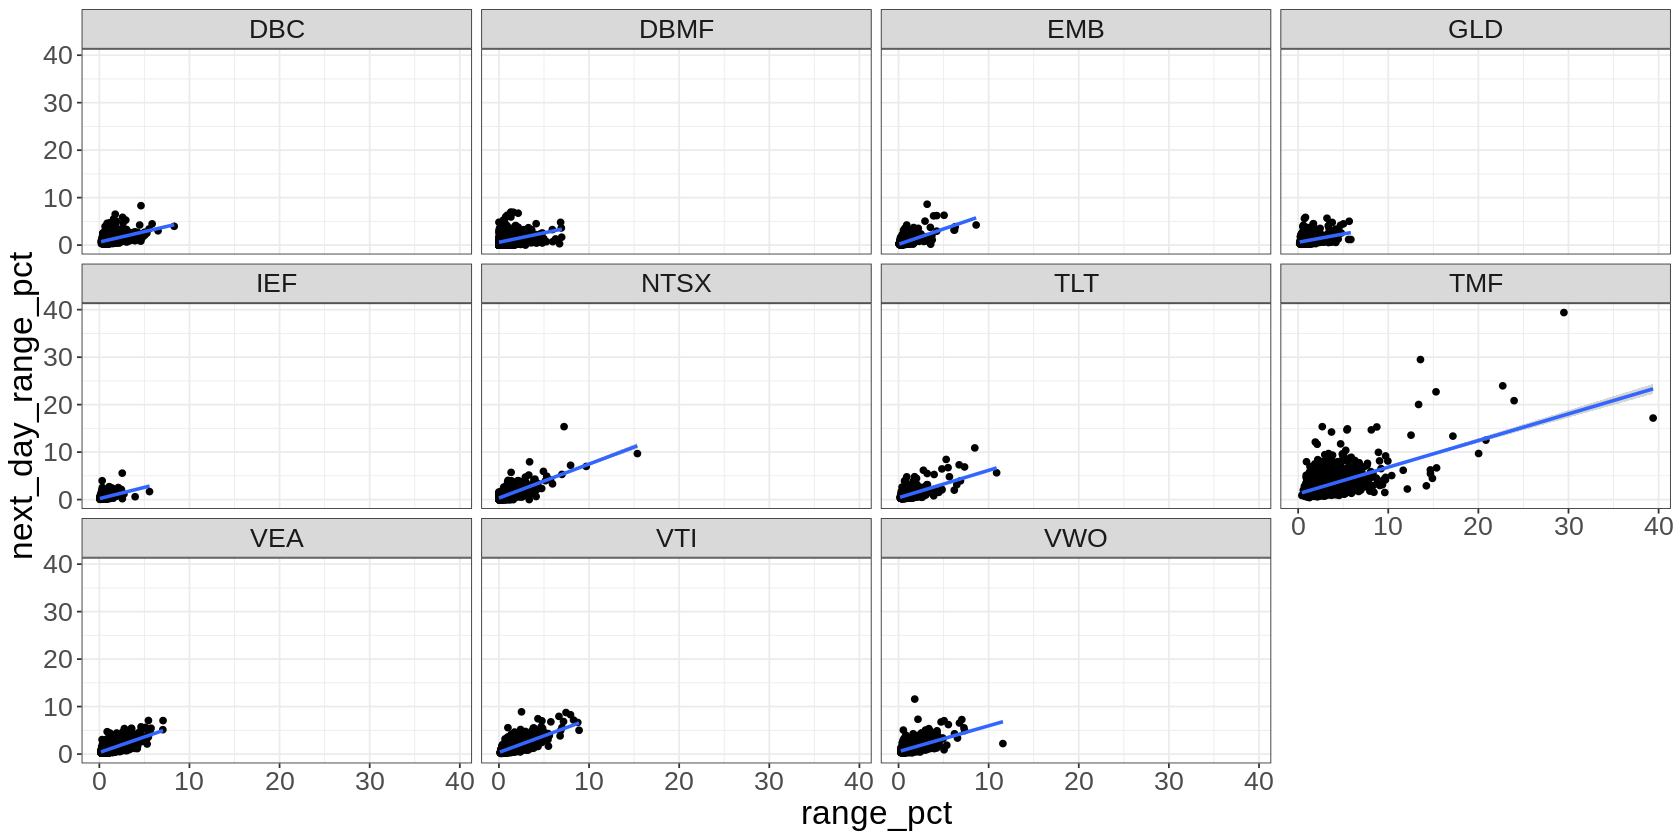

In [13]:
prices %>% 
  filter(date >= '2010-05-07') %>%
  mutate(range_pct = (high/low - 1) * 100) %>%
  group_by(ticker) %>% 
  arrange(date) %>%
  mutate(next_day_range_pct  = lead(range_pct, 1)) %>%
  na.omit() %>%
  ggplot(aes(x=range_pct, y=next_day_range_pct)) + 
    geom_point() + 
    geom_smooth(method = 'lm') +
    facet_wrap(~ticker)

# Example with monthly volatility

If we want to look at periodic volatility, where possible, we can reduce down our data to a lower frequency rather than dealing with overlaps.

In [14]:
VTI %>% head()

ticker,date,open,high,low,close,volume,closeadjusted,range_pct,next_day_range_pct
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VTI,2010-05-07,57.67,58.100,55.840,56.62,5416700,44.677,4.047278,1.553166
VTI,2010-05-10,59.14,59.500,58.590,59.22,4080900,46.729,1.553166,2.217673
VTI,2010-05-11,58.73,59.920,58.620,59.17,2164100,46.690,2.217673,1.394644
VTI,2010-05-12,59.41,60.198,59.370,60.12,1394400,47.439,1.394644,1.585269
VTI,2010-05-13,60.03,60.300,59.359,59.40,1289700,46.871,1.585269,2.232993
VTI,2010-05-14,58.97,59.060,57.770,58.33,1997300,46.027,2.232993,2.653490


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


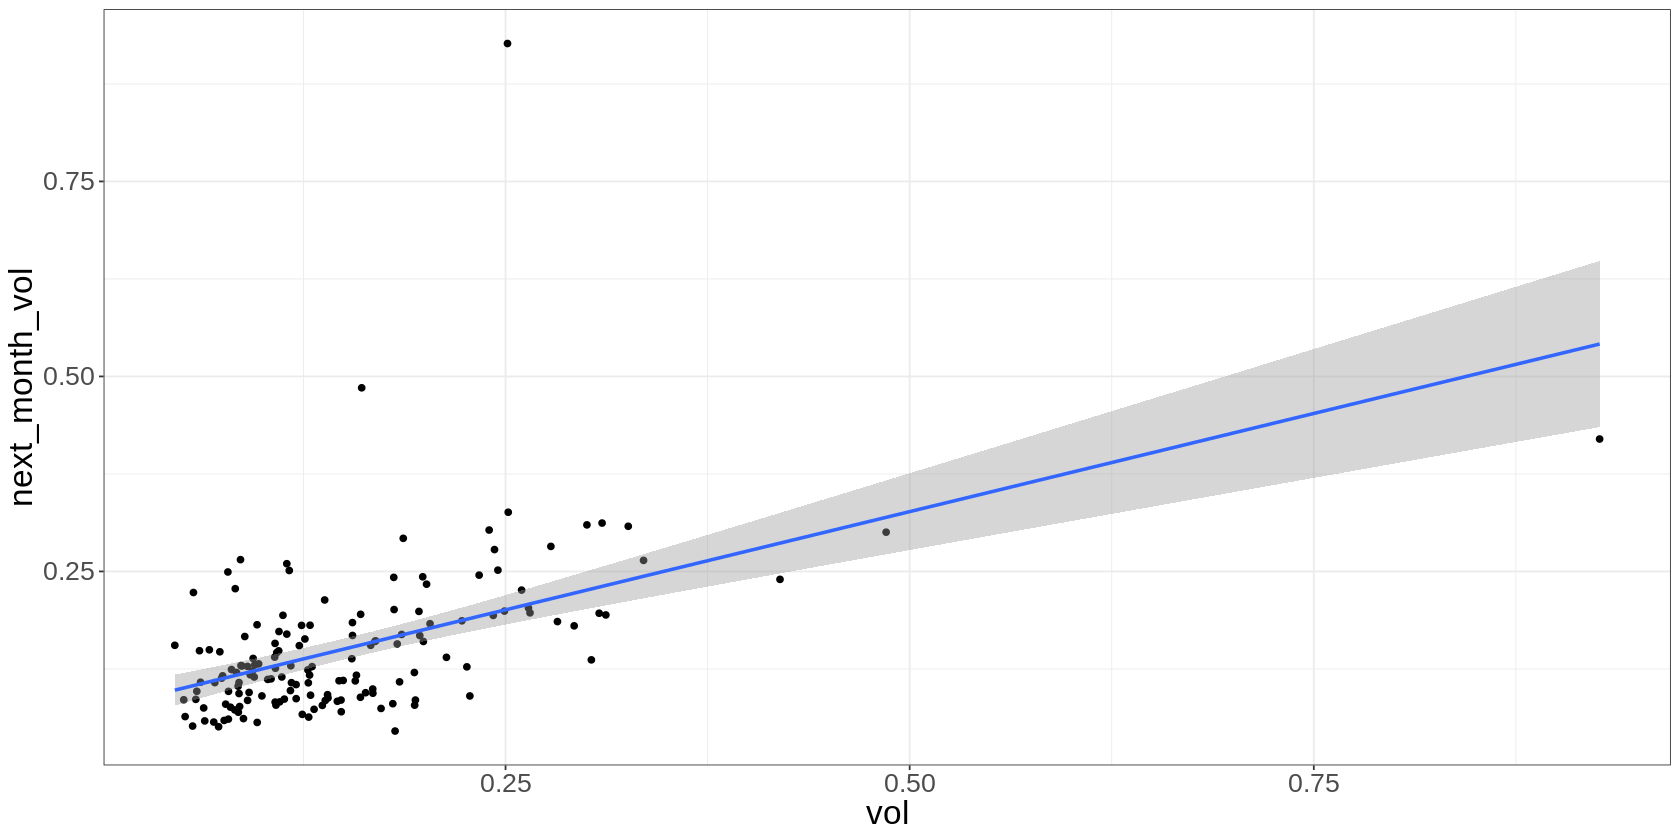

In [15]:
VTI %>% 
  mutate(month = lubridate::floor_date(date, 'month')) %>%
  mutate(returns = log(closeadjusted / lag(closeadjusted))) %>%
  na.omit() %>%
  group_by(month) %>%
  summarize(vol = sd(returns) * sqrt(252)) %>%
  arrange(month) %>%
  mutate(next_month_vol = lead(vol,1)) %>%
  ggplot(aes(x=vol, y = next_month_vol)) + 
    geom_point() +
    geom_smooth(method = 'lm')

# Sometimes we can't avoid overlaps

Where possible, avoid using rolling windows and then throwing away overlaps.

Sometimes you want overlaps or can't avoid it.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


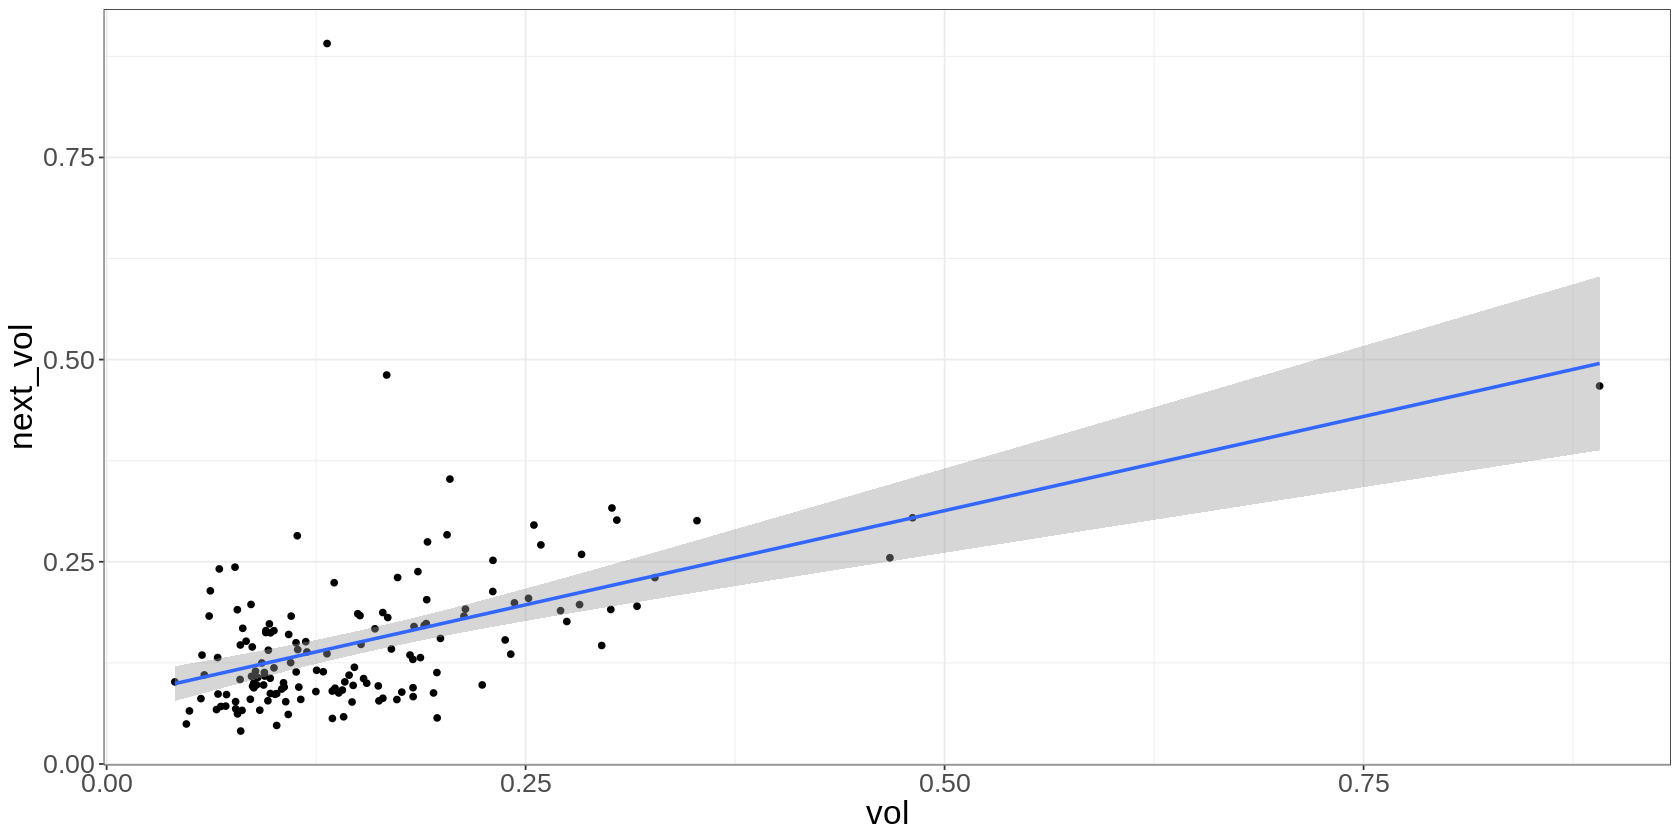

In [16]:
library(roll)

VTI %>% 
  arrange(date) %>%
  mutate(returns = log(closeadjusted / lag(closeadjusted))) %>%
  mutate(vol = roll_sd(returns, 22) * sqrt(252)) %>%
  na.omit() %>%
  mutate(row = row_number() - 1) %>%
  filter(row %% 22 == 0) %>%
  mutate(next_vol = lead(vol, 1)) %>%
  ggplot(aes(x=vol, y=next_vol)) + geom_point() + geom_smooth(method = 'lm')

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


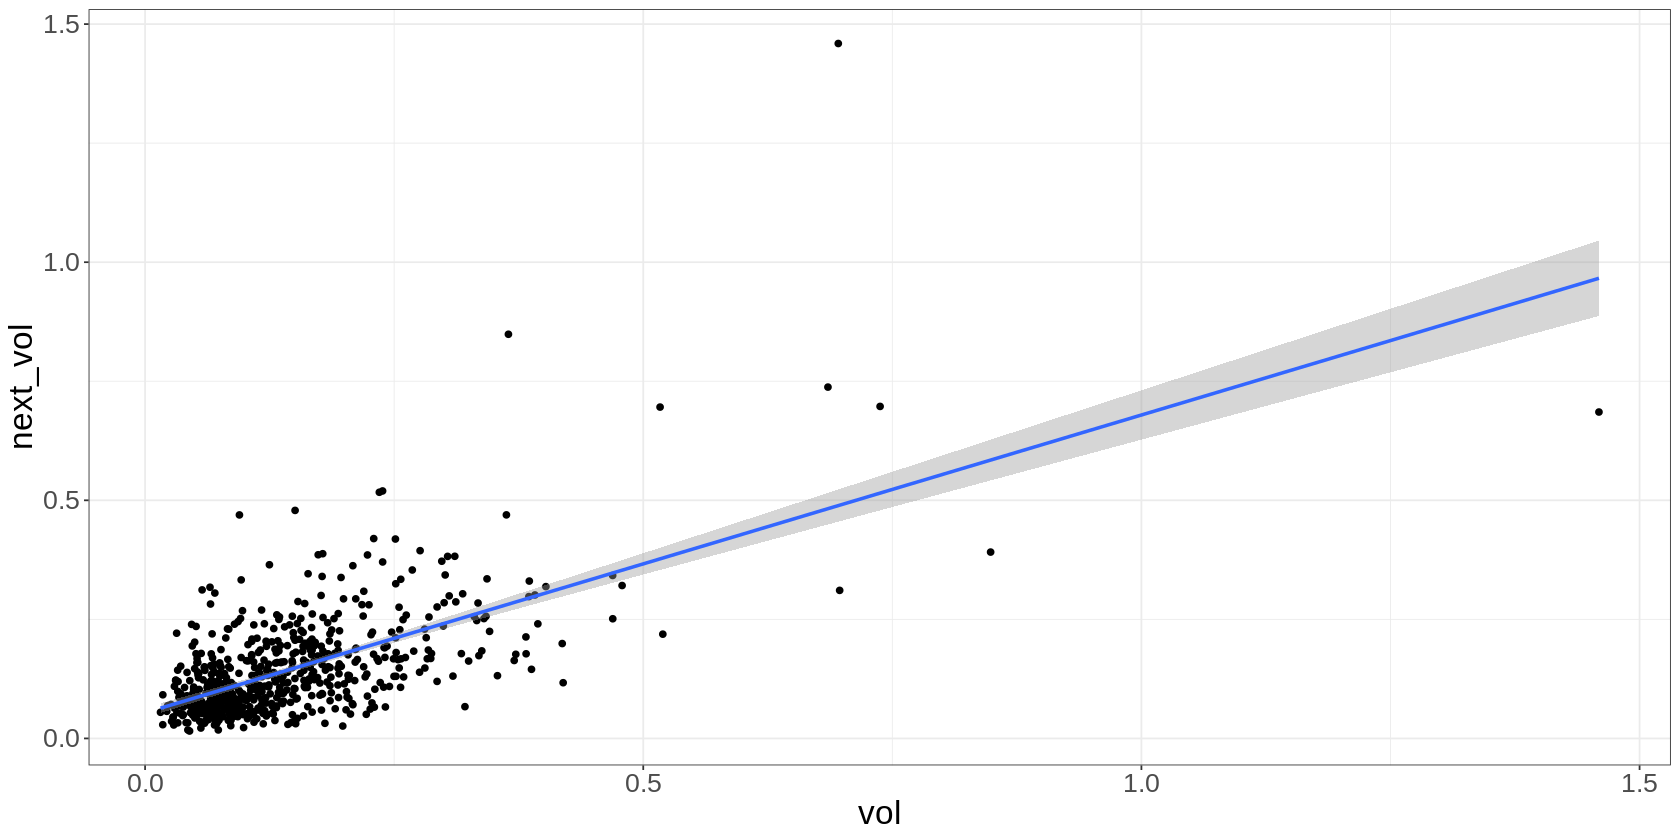

In [17]:
lookback <- 5

VTI %>% 
  arrange(date) %>%
  mutate(returns = log(closeadjusted / lag(closeadjusted))) %>%
  mutate(vol = roll_sd(returns, lookback) * sqrt(252)) %>%
  na.omit() %>%
  filter(row_number() %% lookback == 1) %>%
  mutate(next_vol = lead(vol, 1)) %>%
  ggplot(aes(x=vol, y=next_vol)) + geom_point() + geom_smooth(method = 'lm')